## Random Forest Modelling

### Import relevant libraries and dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from joblib import dump, load

In [2]:
df = pd.read_csv('weatherAUS_imputed.csv')
df.head()

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


In [3]:
#Before starting our modelling, we will define a ROC curve function to dipslay the results 
def roc_curve_custom(model, X, y):
    y_score = model.predict_proba(X)[:, 1] 
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='model')
    roc_display.plot(color='orange', label=f'clf model (auc = {np.round(roc_auc,2)})')
    plt.grid(True)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='Random (auc = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
#We will also define a function to display the confusion matrix and classification_report 
def confusion_matrix_classification_report(y_test, y_pred_test, y_train, y_pred_train):
    #calculate confusion matrix 
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale if needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(y_test, y_pred_test)

    # Print the classification report
    print('-------------------------')
    print(report)

    # Calculate accuracy for both sets
    print('-------------------------')
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

### Random Forest

### 1. Without over or undersampling 

In [7]:
data = df.drop(columns=['RainTomorrow', 'RainToday', 'Location', 'Date'])
target = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### 1.1  Default Random Forest model

In [6]:
#default parameters: n_estimators=100, *, criterion='gini', max_depth=None
rdf = RandomForestClassifier(n_jobs=-1, random_state=321)
rdf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

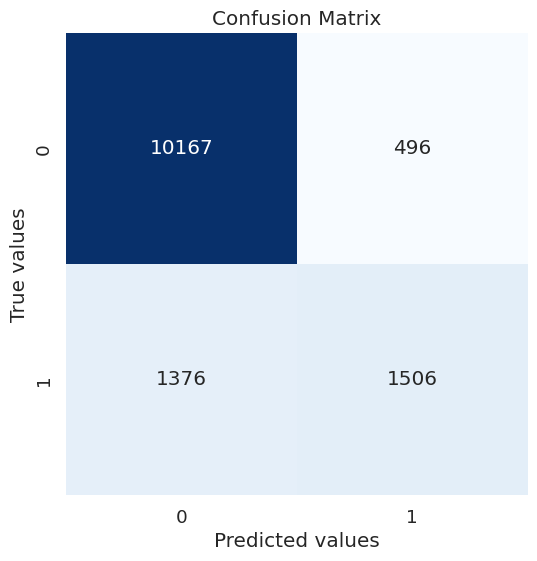

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     10663
         1.0       0.75      0.52      0.62      2882

    accuracy                           0.86     13545
   macro avg       0.82      0.74      0.77     13545
weighted avg       0.85      0.86      0.85     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.862


In [7]:
y_pred_test = rdf.predict(X_test)
y_pred_train = rdf.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test, y_train, y_pred_train)

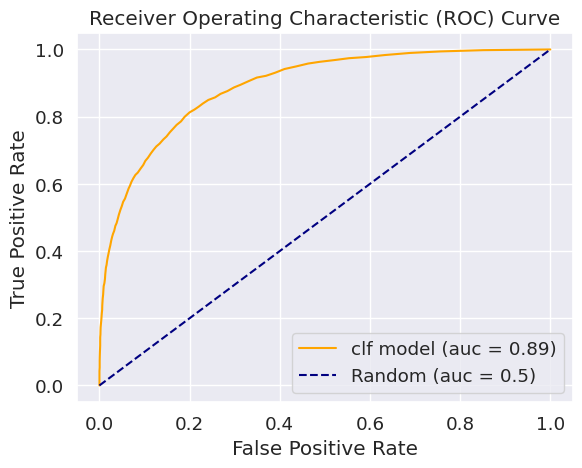

In [8]:
roc_curve_custom(rdf, X_test, y_test)

AUC Value: An AUC value ranges from 0 to 1, where:

AUC = 1 implies a perfect classifier that perfectly separates positive and negative instances.
AUC = 0.5 implies a classifier that performs as good as random guessing.
AUC < 0.5 implies a classifier that performs worse than random guessing.

0.89 AUC: An AUC of 0.89 suggests that the model performs well across a wide range of thresholds. 

The model performs quite well for class 0, with high precision, recall, and F1-score, indicating that it's good at correctly identifying instances of class 0.

However, for class 1, the model's performance is relatively lower, especially in terms of recall (52%). This suggests that the model struggles more to correctly identify instances of class 1,which is likely linked to the imbalance in the dataset or a challenge in distinguishing class 1 instances from others.

The overall accuracy of the model is 86%, which is the proportion of correctly classified instances out of the total instances.

Let's do some hyperparameters tuning for better results.

### 1.2 GridSearch

In [27]:
param_grid = {
    'criterion': ['gini', 'entropy'], # Split criterion
    'n_estimators': [50, 150, 200],   # Number of trees in the forest
    'max_depth': [10, 20, 30],        # Maximum depth of the tree
    'min_samples_split': [3, 5],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4]        # Minimum number of samples required to be at a leaf node
}
nfolds=3

In [28]:
grid_rdf = GridSearchCV(rdf, param_grid, cv=nfolds)

In [29]:
rdf_fit = grid_rdf.fit(X_train, y_train)

In [30]:
dump(rdf_fit, 'rdf_fit.joblib')

['rdf_fit.joblib']

In [31]:
rdf_fit = load('rdf_fit.joblib')
rdf_fit.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 150}

### 1.3 Model with best parameters

In [36]:
rdf_best = RandomForestClassifier(n_jobs=-1, 
                                  criterion = 'entropy',
                                  max_depth = 20,
                                  min_samples_leaf = 2,
                                  min_samples_split = 5,
                                  n_estimators = 150,
                                  random_state=321)
rdf_best.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=150, n_jobs=-1,
                       random_state=321)

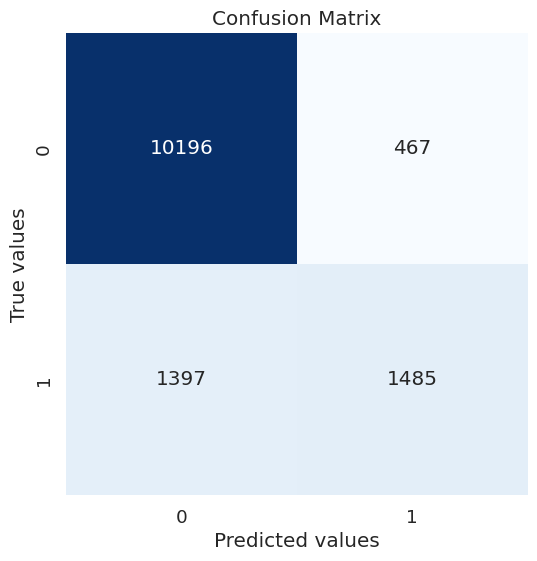

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     10663
         1.0       0.76      0.52      0.61      2882

    accuracy                           0.86     13545
   macro avg       0.82      0.74      0.77     13545
weighted avg       0.85      0.86      0.85     13545

-------------------------
Accuracy Train Set: 0.981 Accuracy Test Set: 0.862


In [37]:
y_pred_test_best = rdf_best.predict(X_test)
y_pred_train_best = rdf_best.predict(X_train)

confusion_matrix_classification_report(y_test, y_pred_test_best, y_train, y_pred_train_best)

### 2. Oversampling

### 2.1 Random Oversampling

In [8]:
ros = RandomOverSampler()
sample_ros = ros.fit_resample(data,target)

In [9]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(sample_ros[0], sample_ros[1], test_size=0.2, random_state=20)

In [12]:
clf_ros = RandomForestClassifier(n_jobs=-1, random_state=321)
clf_ros.fit(X_train_ros,y_train_ros)

RandomForestClassifier(n_jobs=-1, random_state=321)

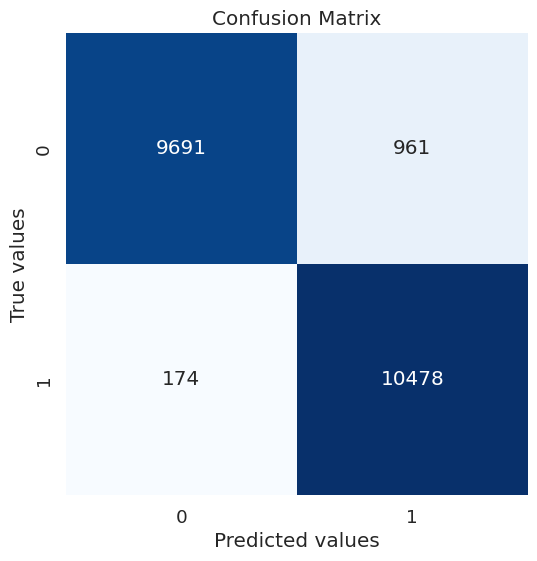

-------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     10652
         1.0       0.92      0.98      0.95     10652

    accuracy                           0.95     21304
   macro avg       0.95      0.95      0.95     21304
weighted avg       0.95      0.95      0.95     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.947


In [13]:
y_pred_ros = clf_ros.predict(X_test_ros)
y_pred_train_ros = clf_ros.predict(X_train_ros)

confusion_matrix_classification_report(y_test_ros, y_pred_ros, y_train_ros, y_pred_train_ros)

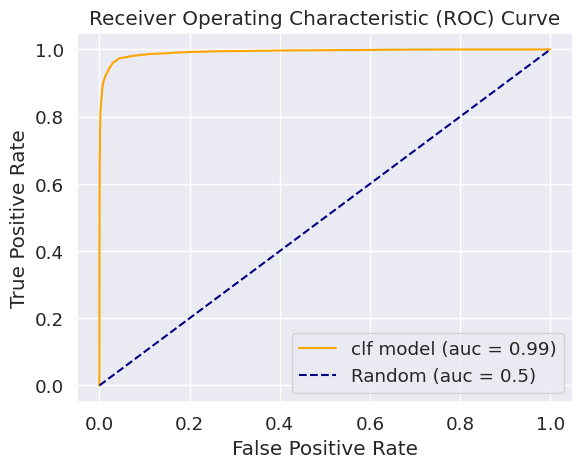

In [47]:
roc_curve_custom(clf_ros, X_test_ros, y_test_ros)

### 2.2 SMOTE 

In [60]:
smo = SMOTE()
sample_sm = smo.fit_resample(data,target)

In [61]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(sample_sm[0], sample_sm[1], test_size=0.2, random_state=20)

In [62]:
clf_sm = RandomForestClassifier(n_jobs=-1, random_state=321)
clf_sm.fit(X_train_sm,y_train_sm)

RandomForestClassifier(n_jobs=-1, random_state=321)

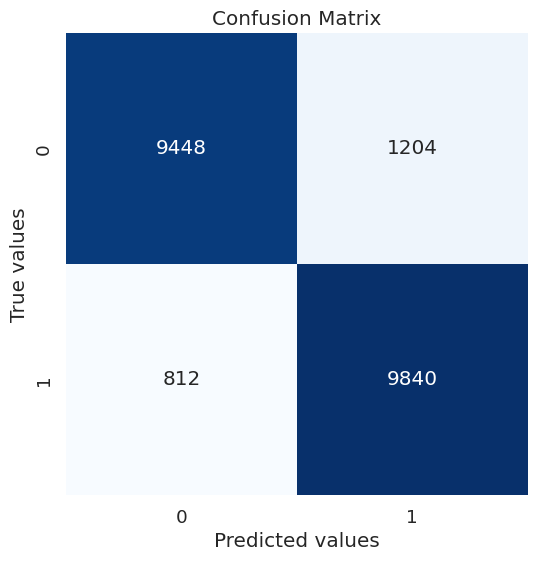

-------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90     10652
         1.0       0.89      0.92      0.91     10652

    accuracy                           0.91     21304
   macro avg       0.91      0.91      0.91     21304
weighted avg       0.91      0.91      0.91     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.905


In [63]:
y_pred_sm = clf_sm.predict(X_test_sm)
y_pred_train_sm = clf_sm.predict(X_train_sm)

confusion_matrix_classification_report(y_test_sm, y_pred_sm, y_train_sm, y_pred_train_sm)

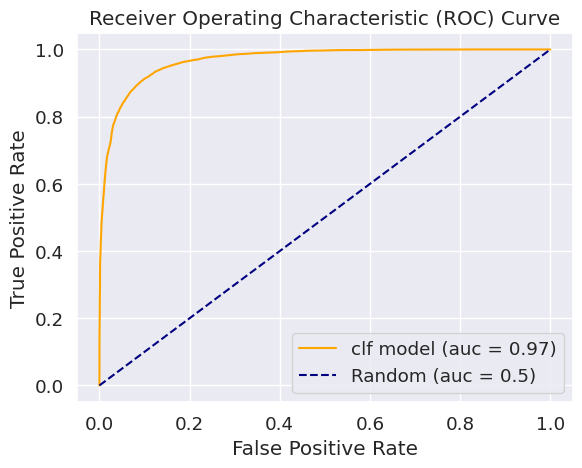

In [64]:
roc_curve_custom(clf_sm, X_test_sm, y_test_sm)

### 3. Undersampling

### 3.1 Random Undersampling

In [65]:
rus = RandomUnderSampler()
sample_rus = rus.fit_resample(data,target)

In [66]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(sample_rus[0], sample_rus[1], test_size=0.2, random_state=42)

In [67]:
clf_rus = RandomForestClassifier(n_jobs=-1, random_state=321)
clf_rus.fit(X_train_rus,y_train_rus)

RandomForestClassifier(n_jobs=-1, random_state=321)

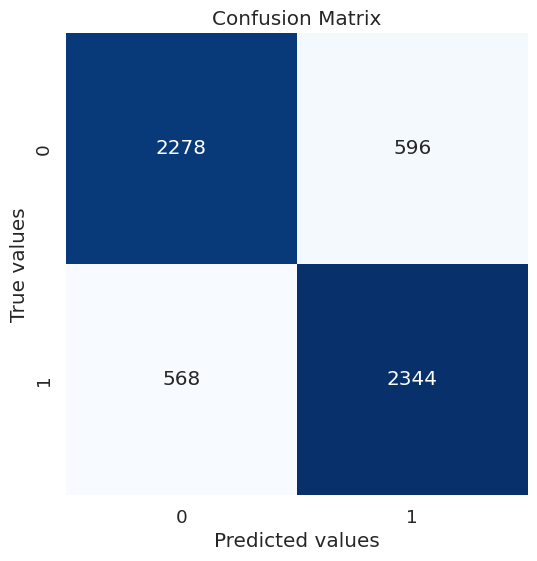

-------------------------
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80      2874
         1.0       0.80      0.80      0.80      2912

    accuracy                           0.80      5786
   macro avg       0.80      0.80      0.80      5786
weighted avg       0.80      0.80      0.80      5786

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.799


In [68]:
y_pred_rus= clf_rus.predict(X_test_rus)
y_pred_train_rus = clf_rus.predict(X_train_rus)
conf_matrix = confusion_matrix(y_test_rus, y_pred_rus)

confusion_matrix_classification_report(y_test_rus, y_pred_rus, y_train_rus, y_pred_train_rus)

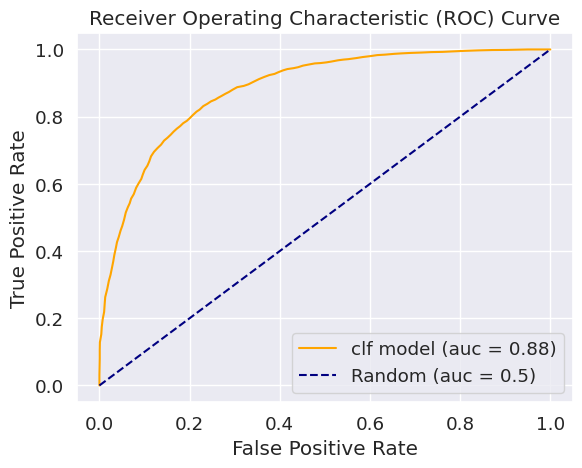

In [69]:
roc_curve_custom(clf_rus, X_test_rus, y_test_rus)

### 4. Conclusion Over/Undersampling

We get the best performance with the RandomOverSampler.

The model demonstrates excellent performance for both classes, with high precision, recall, and F1-score for both class 0 and class 1.

Class 0 has slightly higher precision, while class 1 has slightly higher recall, but their overall F1-scores are equal, indicating a balanced performance.

The overall accuracy of the model is 95%, indicating that it correctly predicts the class for 97% of the instances.

Both macro-average and weighted-average metrics are 95%, suggesting consistent and high-quality predictions across both individual classes and the entire dataset.

Let's see if we can get an even better result if we do some hyperparameter tuning with random_over_sampling. 

### 5. RandomOverSampler Hyperparameter Tuning 

### 5.1 GridSearchCV

In [84]:
clf_rf = RandomForestClassifier(random_state=321)

param_grid = {
    'criterion': ['entropy'],         # Split criterion
    'n_estimators': [150, 200],       # Number of trees in the forest
    'max_depth': [10, 20, 30],        # Maximum depth of the tree
    'min_samples_split': [3, 5],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4],       # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt']
}

grid_cv_ros = GridSearchCV(clf_rf, param_grid, cv=3, refit=True)

In [85]:
rdf_ros_fit1 = grid_cv_ros.fit(X_train_ros, y_train_ros)

In [86]:
dump(rdf_ros_fit1, 'rdf_ros_fit1.joblib')

['rdf_ros_fit1.joblib']

In [87]:
rdf_ros_fit1 = load('rdf_ros_fit1.joblib')
rdf_ros_fit1.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 200}

In [90]:
params = {
    'criterion': ['entropy'],       
    'n_estimators': [500, 1000], 
    'max_features': ['sqrt']
}
grid_cv_ros2 = GridSearchCV(clf_rf, params, cv=3, refit=True)

In [91]:
rdf_ros_fit2 = grid_cv_ros2.fit(X_train_ros, y_train_ros)

In [92]:
dump(rdf_ros_fit2, 'rdf_ros_fit2.joblib')

['rdf_ros_fit2.joblib']

In [5]:
rdf_ros_fit2 = load('rdf_ros_fit2.joblib')
rdf_ros_fit2.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500}

### 5.2 Best Parameter Fit

In [96]:
clf = RandomForestClassifier(n_jobs=-1,criterion='entropy', max_features='sqrt', n_estimators=500,random_state=321)
rdf_ros_best = clf.fit(X_train_ros,y_train_ros)

In [97]:
dump(rdf_ros_best, 'rdf_ros_best.joblib')

In [ ]:
rdf_ros_best = load('rdf_ros_best.joblib')

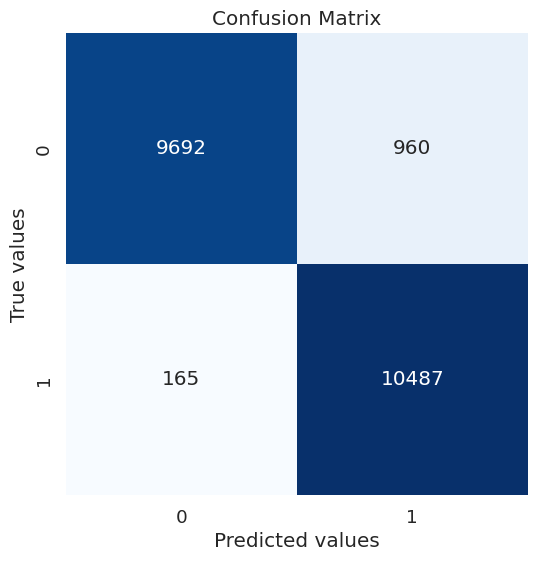

-------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95     10652
         1.0       0.92      0.98      0.95     10652

    accuracy                           0.95     21304
   macro avg       0.95      0.95      0.95     21304
weighted avg       0.95      0.95      0.95     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.947


In [98]:
y_pred_ros_best = rdf_ros_best.predict(X_test_ros)
y_pred_train_ros_best = rdf_ros_best.predict(X_train_ros)

confusion_matrix_classification_report(y_test_ros, y_pred_ros_best, y_train_ros, y_pred_train_ros_best)

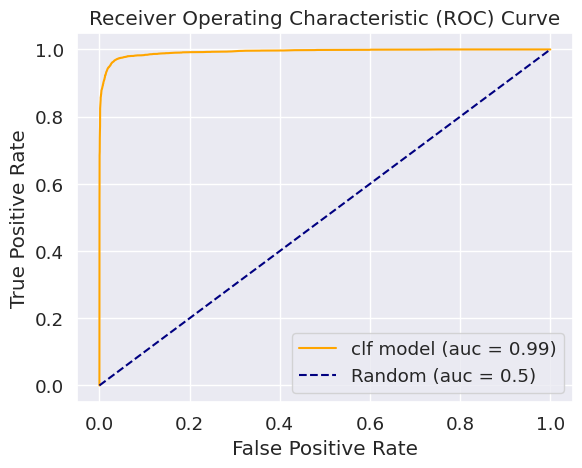

In [197]:
roc_curve_custom(clf_best, X_test_ros, y_test_ros)

Hyperparameter tuning didn't lead to a better result.

### 6. Boosting

In [99]:
ac = AdaBoostClassifier(base_estimator=rdf_ros_best,n_estimators=400)
ac.fit(X_train_ros,y_train_ros)

AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         n_estimators=500,
                                                         n_jobs=-1,
                                                         random_state=321),
                   n_estimators=400)

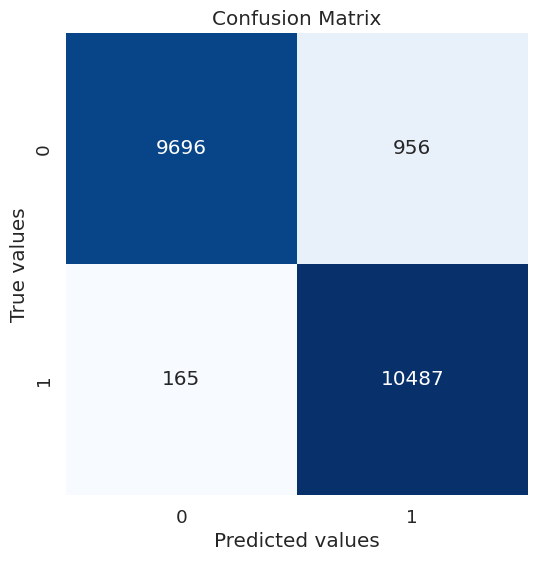

-------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95     10652
         1.0       0.92      0.98      0.95     10652

    accuracy                           0.95     21304
   macro avg       0.95      0.95      0.95     21304
weighted avg       0.95      0.95      0.95     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.947


In [100]:
y_pred_ac = ac.predict(X_test_ros)
y_pred_train_ac = ac.predict(X_train_ros)

confusion_matrix_classification_report(y_test_ros, y_pred_ac, y_train_ros, y_pred_train_ac)

Applying boosting on top of the model did improve the accuracy of the model or any other scores.

### 7. Cross Validation

In [14]:
# Define custom scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

#We take the best performing model with random oversampling to compute the cross validation results
cv_results = cross_validate(clf_ros, X_train_ros, y_train_ros, cv=10, return_estimator=True, scoring=scoring)

In [15]:
dump(cv_results, 'cv_rdf_ros.joblib')

['cv_rdf_ros.joblib']

In [16]:
cv_results = load('cv_rdf_ros.joblib')

In [17]:
from tabulate import tabulate
fold_numbers = range(1,11)
test_precision = cv_results['test_precision']
test_recall = cv_results['test_recall']
test_f1_score = cv_results['test_f1_score']
table = [["Fold", "Test Precision", "Test Recall", "Test F1-Score"]]
for fold, prec, recall, f1 in zip(fold_numbers, test_precision, test_recall, test_f1_score):
    table.append([fold, f"{prec:.3f}", f"{recall:.3f}", f"{f1:.3f}"])

# Print table
print(tabulate(table, headers="firstrow", tablefmt="pretty"))

+------+----------------+-------------+---------------+
| Fold | Test Precision | Test Recall | Test F1-Score |
+------+----------------+-------------+---------------+
|  1   |     0.946      |    0.944    |     0.944     |
|  2   |     0.942      |    0.939    |     0.939     |
|  3   |     0.947      |    0.945    |     0.945     |
|  4   |     0.941      |    0.939    |     0.938     |
|  5   |     0.944      |    0.942    |     0.942     |
|  6   |     0.944      |    0.942    |     0.942     |
|  7   |     0.945      |    0.943    |     0.943     |
|  8   |     0.942      |    0.940    |     0.939     |
|  9   |     0.948      |    0.946    |     0.946     |
|  10  |     0.947      |    0.945    |     0.945     |
+------+----------------+-------------+---------------+


### 8. Feature Importance

Now that we figured out the best fitting model, let's have a look at the feature importance 

Feature ranking:
1. feature 4 (0.165095) - Sunshine
2. feature 12 (0.129871) - Humidity
3. feature 10 (0.096941) - Pressure
4. feature 13 (0.094003) - temp_fluctuation
5. feature 9 (0.088251) - Cloud
6. feature 5 (0.077330) - WindGustSpeed
7. feature 2 (0.062677) - Rainfall
8. feature 11 (0.061500) - Temperature
9. feature 3 (0.051937) - Evaporation
10. feature 6 (0.039729) - WindGustDir_angle
11. feature 8 (0.036705) - Longitude
12. feature 7 (0.033900) - Latitude
13. feature 1 (0.031853) - Month
14. feature 0 (0.030207) - Year


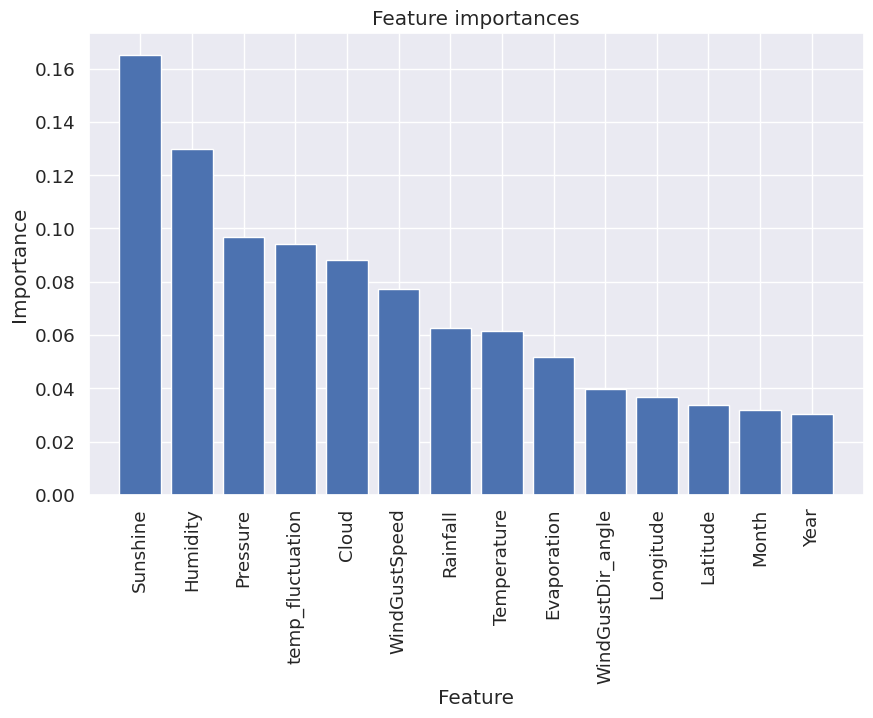

In [19]:
column_names= data.columns 
importances = clf_ros.feature_importances_

# Get indices of features sorted by importance
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X_train_ros.shape[1]):
    print("%d. feature %d (%f) - %s" % (f + 1, indices[f], importances[indices[f]], column_names[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train_ros.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X_train_ros.shape[1]), [column_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train_ros.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

### 9. Conclusion 

We get the best performance with Random Oversampling. Hyperparameter tuning and boosting did not improve our results.

Precision: For class 0, the precision is 0.98, indicating that out of all instances predicted as class 0, 98% were actually class 0. Similarly, for class 1, the precision is 0.92, meaning that out of all instances predicted as class 1, 92% were actually class 1.

Recall: For class 0, the recall is 0.91, indicating that out of all instances that were actually class 0, 91% were correctly predicted as class 0. For class 1, the recall is 0.98, meaning that 98% of instances that were actually class 1.0 were correctly predicted as class 1.

F1-score: The F1-score, which is the harmonic mean of precision and recall, is 0.95 for both classes. These scores indicate a balance between precision and recall for both classes.

Accuracy: The overall accuracy of the model is 0.95, meaning that the model correctly classified 95% of all instances.

Macro Average: The macro average of precision, recall, and F1-score is 0.95, indicating a high performance for both classes when averaged equally.

Weighted Average: The weighted average of precision, recall, and F1-score is also 0.95, taking into account the number of true instances for each class. This suggests that the model performs well overall, with similar performance for both classes.

Overall, Random Forest Classification shows strong performance, with high precision and recall for both classes and an overall accuracy of 95%. It demonstrates the ability to effectively classify instances into their respective classes.

The cross validation results suggest that the best model performs consistently across different folds of the dataset, with precision, recall, and F1-score values ranging between 0.941 to 0.948. 0.938 to 0.946, and 0.939 to 946, respectively. This consistency indicates that the model generalizes well to unseen data and is likely to perform consistently on new datasets.

As for the feature interpretation, we can observe that the 3 most important feature are hours of sunshine with an importance over 0.16, followed by humidity (0.13) and pressure (0.9). 